# Machine Learning for Beer

Your goal is to train a model to predict the bitterness of a beer (in International Bittering Units, or IBU), given features about the beer. You can acquire the data in any one of three places:

- on [Kaggle](https://www.kaggle.com/competitions/beer2022ventura/data) 
- on [Github](https://github.com/dlsun/pods/tree/master/data/beer) (https://dlsun.github.io/pods/data/beer/beer_train.csv and https://dlsun.github.io/pods/data/beer/beer_test.csv )

A description of the variables is available [here](https://www.kaggle.com/competitions/beer2022ventura/data).

## Question 1

You would like to predict **ibu** using a $20$-nearest neighbors model. You are choosing between 4 sets of features to put into this model:

1. **abv**
2. **abv**, **name**
3. **abv**, **name**, **available**
4. **abv**, **name**, **available**, **glass**

Apply TF-IDF (using the top 100 terms) to the raw text variables and one-hot encoding to the categorical variables.  (It is up to you which variables to treat as categorical and which to treat as raw text.)


For each set of features, train a $20$-nearest neighbor model to predict IBU (**ibu**). Which of these models is best for predicting IBU? Justify your answer.

**I treat "name" as a raw text variable.**

In [1]:
import pandas as pd
import numpy as np
beer_train = pd.read_csv("https://dlsun.github.io/pods/data/beer/beer_train.csv")

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

def get_cv_error(features):
  if (len(features) == 1):
      ct = make_column_transformer(
          (StandardScaler(), ["abv"]),
          remainder="drop"
      )
    
  elif (len(features) == 2):
    ct = make_column_transformer(
          (TfidfVectorizer(norm=None, max_features=100), "name"),
          (StandardScaler(), ["abv"]),
          remainder="drop"
      )
  elif (len(features) == 3):
     ct = make_column_transformer(
          (TfidfVectorizer(norm=None, max_features=100), "name"),
          (OneHotEncoder(handle_unknown='ignore'), ["available"]),
          (StandardScaler(), ["abv"]),
          remainder="drop"
      )
  elif (len(features) == 4):
     ct = make_column_transformer(
          (TfidfVectorizer(norm=None, max_features=100), "name"),
          (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
          (StandardScaler(), ["abv"]),
          remainder="drop"
      )
  
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=20)
  )

  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=beer_train[features],
                             y=beer_train["ibu"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()

for features in [["abv"],
                 ["abv", "name"],
                 ["abv", "name", "available"],
                 ["abv", "name", "available", "glass"]]:
  errs[str(features)] = get_cv_error(features)

errs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['abv']                                  650.344005
['abv', 'name']                          563.738715
['abv', 'name', 'available']             563.633697
['abv', 'name', 'available', 'glass']    555.797316
dtype: float64

**The best model for predicting IBU is the last one, with "abv", "name", and "available", and "glass" as predictors. This is because this model produces the smallest error.**

## Question 2

Let's see how the distance metric and the scaling method influence prediction accuracy. Use the set of features from Question 1 that you determined to be the best. Continue to use $k=20$ nearest neighbors, but try fitting models with different distance metrics and scaling methods. Which distance metric and/or scaling method gives the best prediction accuracy?

In [3]:
X_train = beer_train[["abv", "name", "available", "glass"]]
y_train = beer_train["ibu"]

In [4]:
from sklearn.model_selection import cross_val_score

# StandardScaler
ct = make_column_transformer(
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    (StandardScaler(), ["abv"]),
    remainder="drop"
)

pipeline = make_pipeline(
          ct,
          KNeighborsRegressor(n_neighbors=20)
)
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline,
                           X=X_train,
                           y=y_train,
                           scoring="neg_mean_absolute_error",
                           cv=10)
-scores.mean()

14.059304341666666

In [5]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

ct = make_column_transformer(
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    (MinMaxScaler(), ["abv"]),
    remainder="drop"
)

pipeline = make_pipeline(
          ct,
          KNeighborsRegressor(n_neighbors=20)
)
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline,
                           X=X_train,
                           y=y_train,
                           scoring="neg_mean_absolute_error",
                           cv=10)
-scores.mean()

14.209474808333335

In [6]:
# Normalizer
from sklearn.preprocessing import Normalizer

ct = make_column_transformer(
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    (Normalizer(), ["abv"]),
    remainder="drop"
)

pipeline = make_pipeline(
          ct,
          KNeighborsRegressor(n_neighbors=20)
)
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline,
                           X=X_train,
                           y=y_train,
                           scoring="neg_mean_absolute_error",
                           cv=10)
-scores.mean()

15.7698227

**StandardScaler gives the best prediction accuracy.**

## Question 3

Finally, let's determine the right value of $k$. Use the set of features, the distance metric, and the scaling method that you determined to be best (for $k=20$) in Questions 1 and 2. Fit $k$-nearest neighbor models for different values of $k$. Plot the training error and the estimated test error as functions of $k$, and determine the optimal value of $k$.

In [7]:
ct = make_column_transformer(
    (TfidfVectorizer(norm=None, max_features=100), "name"),
    (OneHotEncoder(handle_unknown='ignore'), ["available", "glass"]),
    (StandardScaler(), ["abv"]),
    remainder="drop"
)

In [8]:
from sklearn.metrics import mean_absolute_error

# training error 
maes = {}
for k in range (1, 20):
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )

  pipeline.fit(X=X_train,
               y=y_train)
  
  y_pred = pipeline.predict(X_train)
  
  maes[k] = mean_absolute_error(y_train, y_pred)

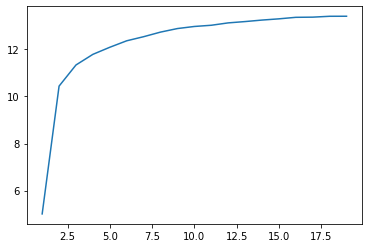

In [9]:
pd.Series(maes).plot.line()

In [10]:
# estimated test error 
maes = {}
for k in range(1, 20):
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )

  scores = cross_val_score(pipeline,
                           X=X_train,
                           y=y_train,
                           scoring="neg_mean_absolute_error",
                           cv=10)
  
  maes[k] = -scores.mean()

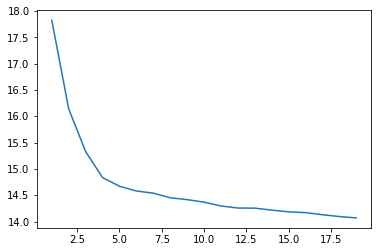

In [11]:
pd.Series(maes).plot.line()

In [12]:
from sklearn.model_selection import GridSearchCV

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor()
)

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_absolute_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=100,
                                                                  norm=None),
                                                  'name'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['available', 'glass']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['abv'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=19))])

**The optimal value of k is 19.**

## Submission Instructions

- Restart this notebook and run the cells from beginning to end:
  - Go to Runtime > Restart and Run All.
- Download the notebook:
  - Go to File > Download > Download .ipynb.
- Submit your notebook file to the assignment on Canvas.